#Импорт необходимых библиотек

In [1]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop # Оптимизаторы
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Матрица ошибок классификатора

#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

# Импорт модулей для предобработки текстовых данных
from keras.preprocessing.text import Tokenizer, text_to_word_sequence, tokenizer_from_json 

# Импорт модуля для кластеризации 
from sklearn.cluster import KMeans 



#Загрузка данных, проверка содержимого

In [2]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#filename_1 = '/content/drive/MyDrive/Profpatolog/dataset_profpatolog_1.xlsx'
#filename_2 = '/content/drive/MyDrive/Profpatolog/dataset_profpatolog_2.xlsx'
filename_1 = '/content/drive/MyDrive/Profpatolog/dataset_profpatolog_1.csv'
filename_2 = '/content/drive/MyDrive/Profpatolog/dataset_profpatolog_2.csv'

In [4]:
df = pd.read_csv(filename_1)

In [5]:
# Количество резюме и критерии
print(df.shape)

(112, 710)


In [ ]:
df

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Стоматология1_Классификация1Представление2,Стоматология1_Классификация22,Стоматология1_Классификация2Представление2,Стоматология1_Классификация32,Стоматология1_Классификация3Представление2,Стоматология1_Противопоказание2,Стоматология1_ПротивопоказаниеПредставление2,Стоматология1_Профессиональное2,Стоматология1_ПрофнепригодностьВременная2,Стоматология1_ПрофнепригодностьВременнаяПредставление2
0,9688ac7c-dd74-11ec-8100-0cc47aab8067,11ba74dd-5503-11e8-80ce-0cc47aab8067,1972-03-05,Женский,Женский,2022-05-27,Периодический,Периодический,0.0,a1e92db1-2ea1-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,df26abd0-dfdc-11ec-8100-0cc47aab8067,11ba74df-5503-11e8-80ce-0cc47aab8067,1988-09-16,Женский,Женский,2022-05-30,Периодический,Периодический,0.0,a1e92db1-2ea1-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8c158fb4-dfe4-11ec-8100-0cc47aab8067,5f637b0b-dd0e-11ec-8100-0cc47aab8067,2002-05-26,Женский,Женский,2022-05-30,Периодический,Периодический,0.0,a1e92db1-2ea1-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,456762a8-e092-11ec-8101-0cc47aab8067,11ba74e4-5503-11e8-80ce-0cc47aab8067,1968-03-16,Женский,Женский,2022-05-31,Периодический,Периодический,0.0,a1e92db1-2ea1-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,412031b1-e095-11ec-8101-0cc47aab8067,7afbc5e9-0c2d-11ea-80d3-0cc47aab8067,1974-06-17,Женский,Женский,2022-05-31,Периодический,Периодический,0.0,a1e92db1-2ea1-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,01347bd0-6fa4-11ed-8109-0cc47aab8067,46869f09-6efc-11ed-8109-0cc47aab8067,1983-11-18,Мужской,Мужской,2022-11-29,Периодический,Периодический,0.0,04d5e72c-6efc-11ed-8109-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,10652eec-6fa5-11ed-8109-0cc47aab8067,c777b932-51ad-11ec-80fc-0cc47aab8067,1987-08-19,Женский,Женский,2022-11-29,Периодический,Периодический,0.0,b6882c37-6716-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,f1beb089-6fa8-11ed-8109-0cc47aab8067,abd2610d-1832-11e7-80d3-708bcd7f83cd,1980-06-25,Мужской,Мужской,2022-11-29,Периодический,Периодический,1.0,173d6ba7-12fe-11e7-80d3-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,c4ebcfec-6fac-11ed-8109-0cc47aab8067,fccc048a-b984-11e7-80de-708bcd7f83cd,1966-01-26,Мужской,Мужской,2022-11-29,Периодический,Периодический,1.0,173d6ba7-12fe-11e7-80d3-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.count()

ДокументПрохождениеМедосмотра                             112
Клиент                                                    110
КлиентДатаРождения                                        110
КлиентПол                                                 110
КлиентПолПредставление                                    110
                                                         ... 
Стоматология1_Противопоказание2                             2
Стоматология1_ПротивопоказаниеПредставление2                0
Стоматология1_Профессиональное2                             2
Стоматология1_ПрофнепригодностьВременная2                   0
Стоматология1_ПрофнепригодностьВременнаяПредставление2      0
Length: 710, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Columns: 710 entries, ДокументПрохождениеМедосмотра to Стоматология1_ПрофнепригодностьВременнаяПредставление2
dtypes: float64(267), object(443)
memory usage: 621.4+ KB


#Работа с данными в таблице

In [6]:
df1 = df.dropna(axis=0, how='all')
df2 = df1.dropna(axis=1, how='all')

In [7]:
print(df2.shape)

(112, 470)


In [8]:
colms = df2.columns.values.tolist()

In [ ]:
colms

['ДокументПрохождениеМедосмотра',
 'Клиент',
 'КлиентДатаРождения',
 'КлиентПол',
 'КлиентПолПредставление',
 'ДатаЗавершенияМедосмотра',
 'ТипМедосмотра',
 'ТипМедосмотраПредставление',
 'ПсихОсвидетельствование',
 'Контрагент',
 'Цех',
 'Профессия',
 'ЗаключениеМК',
 'ЗаключениеМКПредставление',
 'Заключение',
 'ДиспансернаяГруппа',
 'ДиспансернаяГруппаПредставление',
 'ВредныеФакторы',
 'Функциональная_Диагностика1_ДокументПрием',
 'Функциональная_Диагностика1_ДатаПриема',
 'Функциональная_Диагностика1_Салон',
 'Функциональная_Диагностика1_СалонПредставление',
 'Функциональная_Диагностика1_Специализация',
 'Функциональная_Диагностика1_СпециализацияПредставление',
 'Функциональная_Диагностика1_ХР_Рекомендация1',
 'Функциональная_Диагностика1_ХР_Рекомендация1Представление',
 'Функциональная_Диагностика1_ХР_Рекомендация2',
 'Функциональная_Диагностика1_ХР_Рекомендация2Представление',
 'Функциональная_Диагностика1_ХР_РекомендацияСтр',
 'Оториноларингология1_ДокументПрием',
 'Оторинолари

In [ ]:
colms[3]

'КлиентПол'

In [ ]:
df2[colms[3]].unique()

array(['Женский', 'Мужской', nan], dtype=object)

In [ ]:
df2[colms[3]].nunique()

2

In [ ]:
print(df2.iloc[33])

ДокументПрохождениеМедосмотра                                    назначено лечение."
Клиент                                                                           NaN
КлиентДатаРождения                                                               NaN
КлиентПол                                                                        NaN
КлиентПолПредставление                                                           NaN
                                                                        ...         
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                    NaN
Стоматология1_МКБ102                                                             NaN
Стоматология1_ДиагнозПредставление2                                              NaN
Стоматология1_Противопоказание2                                                  NaN
Стоматология1_Профессиональное2                                                  NaN
Name: 33, Length: 470, dtype: object


In [ ]:
print(df2.iloc[60])

ДокументПрохождениеМедосмотра                                    конс сурдолога к след мед осмотру."
Клиент                                                                                           NaN
КлиентДатаРождения                                                                               NaN
КлиентПол                                                                                        NaN
КлиентПолПредставление                                                                           NaN
                                                                                ...                 
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                                    NaN
Стоматология1_МКБ102                                                                             NaN
Стоматология1_ДиагнозПредставление2                                                              NaN
Стоматология1_Противопоказание2                                                            

In [ ]:
print(df2.iloc[102])

ДокументПрохождениеМедосмотра                                    5111c520-7746-11ec-80fc-0cc47aab8067
Клиент                                                           1c5a75f1-7744-11ec-80fc-0cc47aab8067
КлиентДатаРождения                                                                         1975-06-11
КлиентПол                                                                                     Мужской
КлиентПолПредставление                                                                        Мужской
                                                                                 ...                 
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                                   Годен
Стоматология1_МКБ102                                                                              NaN
Стоматология1_ДиагнозПредставление2                                                               NaN
Стоматология1_Противопоказание2                                                   

In [ ]:
print(df2.iloc[37])

ДокументПрохождениеМедосмотра                                    eab3ac0a-484c-11ed-8107-0cc47aab8067
Клиент                                                           ddb457d3-1451-11e7-80d3-708bcd7f83cd
КлиентДатаРождения                                                                         1986-07-23
КлиентПол                                                                                     Мужской
КлиентПолПредставление                                                                        Мужской
                                                                                 ...                 
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                                     NaN
Стоматология1_МКБ102                                                                              NaN
Стоматология1_ДиагнозПредставление2                                                               NaN
Стоматология1_Противопоказание2                                                   

In [ ]:
print(df2.iloc[84])

ДокументПрохождениеМедосмотра                                    fc62264f-55aa-11ed-8108-0cc47aab8067
Клиент                                                           116fe6a3-455f-11ed-8107-0cc47aab8067
КлиентДатаРождения                                                                         1968-07-22
КлиентПол                                                                                     Мужской
КлиентПолПредставление                                                                        Мужской
                                                                                 ...                 
Оториноларингология2_ПрофнепригодностьВременнаяПредставление1                                     NaN
Стоматология1_МКБ102                                                                              NaN
Стоматология1_ДиагнозПредставление2                                                               NaN
Стоматология1_Противопоказание2                                                   

In [9]:
df3 = df2.drop (index=[ 33, 60, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111])

In [10]:
# Количество строк и столбцов
print(df3.shape)

(100, 470)


In [141]:
data = []
for col in colms:
    tp = df3[col].dtypes
    q = df3[col].unique()
    nq = df3[col].nunique()
    data.append([col, tp, nq, q])

In [142]:
df_col = pd.DataFrame(data, columns=['Название', 'Тип', 'Кол-во уник.знач.', 'Уник.значения'])

In [ ]:
df_col[0:17]

,Название,Тип,Кол-во уник.знач.,Уник.значения
0,ДокументПрохождениеМедосмотра,object,100,"[9688ac7c-dd74-11ec-8100-0cc47aab8067, df26abd..."
1,Клиент,object,100,"[11ba74dd-5503-11e8-80ce-0cc47aab8067, 11ba74d..."
2,КлиентДатаРождения,object,99,"[1972-03-05, 1988-09-16, 2002-05-26, 1968-03-1..."
3,КлиентПол,object,2,"[Женский, Мужской]"
4,КлиентПолПредставление,object,2,"[Женский, Мужской]"
5,ДатаЗавершенияМедосмотра,object,24,"[2022-05-27, 2022-05-30, 2022-05-31, 2022-06-0..."
6,ТипМедосмотра,object,1,[Периодический]
7,ТипМедосмотраПредставление,object,1,[Периодический]
8,ПсихОсвидетельствование,float64,2,"[0.0, 1.0]"
9,Контрагент,object,13,"[a1e92db1-2ea1-11e9-80ce-0cc47aab8067, e8b7052..."


In [ ]:
df_col.iloc[12][3]

array(['ГоденСКоррекциейЗрения', 'Годен', 'ГоденБезРаботНаВысотах',
       'ВременноНегоден', 'ОграниченноГоден'], dtype=object)

In [ ]:
df_col.iloc[13][3]

array(['Годен к работе в указанных условиях (с коррекцией зрения)',
       'Годен к работе в указанных условиях',
       'Годен к работе в указанных условиях (без работ на высотах)',
       'Временно не годен', 'Ограниченно годен'], dtype=object)

In [ ]:
df_col.iloc[14][3]

array(['Годен к работе в указанных условиях (с коррекцией зрения), кроме п.6.1',
       'Годен к работе в указанных условиях',
       'Годен к работе в указанных условиях (с коррекцией зрения)',
       'Годен к работе в указанных условиях (без работ на высотах) Противопоказана работа связанная с  высотой ,подьем и перемещение тяжестей ,длительной ходьбой.',
       'Временно не годен', 'Ограниченно годен',
       'Годен к работе в указанных условиях, кроме п 6.2', nan],
      dtype=object)

In [ ]:
df_col.iloc[15][3]

array(['II', 'I', 'IIIа', 'IIIб'], dtype=object)

In [ ]:
df_col[17:50]

,Название,Тип,Кол-во уник.знач.,Уник.значения
17,ВредныеФакторы,object,40,"[5.1,6.1,6.2, 5.1,6, 4.2.5, 5.1,6.2,6.1, 5.1, ..."
18,Функциональная_Диагностика1_ДокументПрием,object,87,"[25288a29-dd75-11ec-8100-0cc47aab8067, c859a36..."
19,Функциональная_Диагностика1_ДатаПриема,object,87,"[2022-05-27 09:26:22, 2022-05-30 12:04:51, 202..."
20,Функциональная_Диагностика1_Салон,object,1,"[1b071e3e-c87a-11e7-80de-708bcd7f83cd, nan]"
21,Функциональная_Диагностика1_СалонПредставление,object,1,"[МЦ№2, nan]"
22,Функциональная_Диагностика1_Специализация,object,1,"[74e3ecc5-4180-11e8-80ca-0cc47aab8067, nan]"
23,Функциональная_Диагностика1_СпециализацияПредс...,object,1,"[Функциональная диагностика, nan]"
24,Функциональная_Диагностика1_ХР_Рекомендация1,object,1,"[00000000-0000-0000-0000-000000000000, nan]"
25,Функциональная_Диагностика1_ХР_Рекомендация1Пр...,object,0,[nan]
26,Функциональная_Диагностика1_ХР_Рекомендация2,object,1,"[00000000-0000-0000-0000-000000000000, nan]"


In [143]:
df_col.iloc[17][3]

array(['5.1,6.1,6.2', '5.1,6', '4.2.5', '5.1,6.2,6.1', '5.1', '6.1,9,15',
       '4.7,4.8,5.1', '6.1,15', '18.1', '11.1,18.2', '25', '6.2,9', '23',
       '18,18.1,18.2', '11.1,18.1,18.2', '4.7,5.1,11.1', '11.1,18.1',
       '8,11.1,18.2', '4.3.1,4.3.2,8', '6.1,9', '4.4,5.1,6.1,15', '15',
       '9,6.2', '4.2.5,6.2,9', '18.1,22', '4.2.5,6.2,9,27',
       '1.36,4.7,5.1,11.1', '1.29.1,5.1,6.1,9,11.1,15', '23,25', '22',
       '4.1,6.2,18.1,18.2', '4.1,6.2', '4.1,4.2.5,4.4', '6.2,4.1', '4.1',
       '4.1,4.2.5', '4.1,4.7,4.8,5.1', '4.2.5,6.2', '4.1,4.7,4.8,5.1,6.2',
       '9,6.1,6.2'], dtype=object)

In [ ]:
df_col[50:77]

,Название,Тип,Кол-во уник.знач.,Уник.значения
50,Гинекология1_ДокументПрием,object,33,"[269e6706-dd78-11ec-8100-0cc47aab8067, ec9eef5..."
51,Гинекология1_ДатаПриема,object,33,"[2022-05-27T09:47:50, 2022-05-30T11:22:54, 202..."
52,Гинекология1_Салон,object,2,"[1b071e3e-c87a-11e7-80de-708bcd7f83cd, nan, 09..."
53,Гинекология1_СалонПредставление,object,2,"[МЦ№2, nan, МЦ№1]"
54,Гинекология1_Специализация,object,1,"[5d989b1b-aa57-11ea-80dd-0cc47aab8067, nan]"
55,Гинекология1_СпециализацияПредставление,object,1,"[Гинекология, nan]"
56,Гинекология1_ХР_Рекомендация1,object,5,"[16ab2b83-4da3-11ec-80fa-0cc47aab8067, 0000000..."
57,Гинекология1_ХР_Рекомендация1Представление,object,4,"[УЗИ органов малого таза на 6-10 день м.ц., na..."
58,Гинекология1_ХР_Рекомендация2,object,2,"[085ff34d-4da3-11ec-80fa-0cc47aab8067, 0000000..."
59,Гинекология1_ХР_Рекомендация2Представление,object,1,"[Обследование и лечение гинеколога, nan]"


In [ ]:
df_col[77:120]

,Название,Тип,Кол-во уник.знач.,Уник.значения
77,Офтальмология1_ДокументПрием,object,78,"[4503632a-dd79-11ec-8100-0cc47aab8067, e8ea84e..."
78,Офтальмология1_ДатаПриема,object,78,"[2022-05-27 09:55:56, 2022-05-30 11:58:39, 202..."
79,Офтальмология1_Салон,object,1,"[1b071e3e-c87a-11e7-80de-708bcd7f83cd, nan]"
80,Офтальмология1_СалонПредставление,object,1,"[МЦ№2, nan]"
81,Офтальмология1_Специализация,object,1,"[785d8a6e-5c72-11dd-8423-005056c00008, nan]"
82,Офтальмология1_СпециализацияПредставление,object,1,"[Офтальмология, nan]"
83,Офтальмология1_ХР_Рекомендация1,object,5,"[9e952964-53f1-11ec-80fc-0cc47aab8067, 0000000..."
84,Офтальмология1_ХР_Рекомендация1Представление,object,4,[Допуск с ношением средств оптической коррекци...
85,Офтальмология1_ХР_Рекомендация2,object,2,"[00000000-0000-0000-0000-000000000000, nan, 8d..."
86,Офтальмология1_ХР_Рекомендация2Представление,object,1,"[nan, Измерение внутриглазного давления]"


In [ ]:
df_col.iloc[100][3]

array(['ХР_ГоденКромеПунктов', 'БИТУФА_НеВыявлена', nan], dtype=object)

In [ ]:
df_col.iloc[101][3]

array(['Годен, кроме п.', 'Годен', nan], dtype=object)

In [ ]:
df_col[120:171]

,Название,Тип,Кол-во уник.знач.,Уник.значения
120,УЗИ_Диагностика1_ДокументПрием,object,50,"[c8b7639c-dd7a-11ec-8100-0cc47aab8067, c5bf139..."
121,УЗИ_Диагностика1_ДатаПриема,object,50,"[2022-05-27 10:06:44, 2022-05-30 12:11:55, 202..."
122,УЗИ_Диагностика1_Салон,object,2,"[1b071e3e-c87a-11e7-80de-708bcd7f83cd, nan, 09..."
123,УЗИ_Диагностика1_СалонПредставление,object,2,"[МЦ№2, nan, МЦ№1]"
124,УЗИ_Диагностика1_Специализация,object,1,"[3252ceb7-fc4b-11e3-87f5-002618dcef2c, nan]"
125,УЗИ_Диагностика1_СпециализацияПредставление,object,1,"[УЗИ-диагностика, nan]"
126,УЗИ_Диагностика1_ХР_Рекомендация1,object,1,"[00000000-0000-0000-0000-000000000000, nan]"
127,УЗИ_Диагностика1_ХР_Рекомендация2,object,1,"[00000000-0000-0000-0000-000000000000, nan]"
128,Психиатрия_Наркология1_ДокументПрием,object,91,"[e9a209dc-dd7a-11ec-8100-0cc47aab8067, 77ba6ca..."
129,Психиатрия_Наркология1_ДатаПриема,object,91,"[2022-05-27 10:07:34, 2022-05-30 11:48:13, 202..."


In [ ]:
df_col[171:231]

,Название,Тип,Кол-во уник.знач.,Уник.значения
171,Неврология1_ДокументПрием,object,91,"[cfa703fe-dd7b-11ec-8100-0cc47aab8067, 981e0e7..."
172,Неврология1_ДатаПриема,object,91,"[2022-05-27 10:14:01, 2022-05-30 11:49:11, 202..."
173,Неврология1_Салон,object,2,"[1b071e3e-c87a-11e7-80de-708bcd7f83cd, nan, 09..."
174,Неврология1_СалонПредставление,object,2,"[МЦ№2, nan, МЦ№1]"
175,Неврология1_Специализация,object,1,"[c099f7d1-aa57-11ea-80dd-0cc47aab8067, nan]"
176,Неврология1_СпециализацияПредставление,object,1,"[Неврология, nan]"
177,Неврология1_ХР_Рекомендация1,object,1,"[00000000-0000-0000-0000-000000000000, nan]"
178,Неврология1_ХР_Рекомендация2,object,1,"[00000000-0000-0000-0000-000000000000, nan]"
179,Неврология1_МКБ101,object,3,"[Z00.0, nan, G12.1, M42.1]"
180,Неврология1_ДиагнозПредставление1,object,3,"[Общий медицинский осмотр, nan, Другие наследс..."


In [ ]:
df_col.iloc[188][3]

array(['БИТУФА_НеВыявлена', nan, 'ХР_ГоденКромеПунктов'], dtype=object)

In [ ]:
df_col.iloc[189][3]

array(['Годен', nan, 'Годен, кроме п.'], dtype=object)

In [ ]:
df_col[231:287]

,Название,Тип,Кол-во уник.знач.,Уник.значения
231,Дерматовенерология1_ХР_Рекомендация2,object,2,"[nan, 00000000-0000-0000-0000-000000000000, d8..."
232,Дерматовенерология1_ХР_Рекомендация2Представление,object,1,"[nan, Диспансерное наблюдение дерматолога]"
233,Дерматовенерология1_ХР_РекомендацияСтр,object,1,"[nan, сан-кур лечение]"
234,Дерматовенерология1_МКБ101,object,2,"[nan, Z00.0, L40.0]"
235,Дерматовенерология1_ДиагнозПредставление1,object,2,"[nan, Общий медицинский осмотр, Псориаз обыкно..."
236,Дерматовенерология1_Классификация11,object,1,"[nan, Окончательный]"
237,Дерматовенерология1_Классификация1Представление1,object,1,"[nan, Заключительный клинический]"
238,Дерматовенерология1_Классификация21,object,1,"[nan, ХроническоеВпервыеВыявленное]"
239,Дерматовенерология1_Классификация2Представление1,object,1,"[nan, Хроническое, впервые выявленное]"
240,Дерматовенерология1_Противопоказание1,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"


In [ ]:
df_col[287:341]

,Название,Тип,Кол-во уник.знач.,Уник.значения
287,Лабораторные_Исследования2_ДокументПрием,object,1,"[nan, 364d7132-e246-11ec-8101-0cc47aab8067]"
288,Лабораторные_Исследования2_ДатаПриема,object,1,"[nan, 2022-06-02 12:32:53]"
289,Лабораторные_Исследования2_Салон,object,1,"[nan, 1b071e3e-c87a-11e7-80de-708bcd7f83cd]"
290,Лабораторные_Исследования2_СалонПредставление,object,1,"[nan, МЦ№2]"
291,Лабораторные_Исследования2_Специализация,object,1,"[nan, e866ea50-093d-11e2-87b2-002618dcef2c]"
292,Лабораторные_Исследования2_СпециализацияПредст...,object,1,"[nan, Лабораторные исследования]"
293,Лабораторные_Исследования2_ХР_Рекомендация1,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
294,Лабораторные_Исследования2_ХР_Рекомендация2,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
295,Лабораторные_Исследования2_МКБ101,object,1,"[nan, Z00.0]"
296,Лабораторные_Исследования2_ДиагнозПредставление1,object,1,"[nan, Общий медицинский осмотр]"


In [ ]:
df_col[341:401]

,Название,Тип,Кол-во уник.знач.,Уник.значения
341,Психиатрия1_ДокументПрием,object,1,"[nan, 2ffae44f-7dcc-412f-9140-647ce4ba17df]"
342,Психиатрия1_ДатаПриема,object,1,"[nan, 2022-10-03 14:08:38]"
343,Психиатрия1_Салон,object,1,"[nan, 1b071e3e-c87a-11e7-80de-708bcd7f83cd]"
344,Психиатрия1_СалонПредставление,object,1,"[nan, МЦ№2]"
345,Психиатрия1_Специализация,object,1,"[nan, 2787899d-aa58-11ea-80dd-0cc47aab8067]"
346,Психиатрия1_СпециализацияПредставление,object,1,"[nan, Психиатрия]"
347,Психиатрия1_ХР_Рекомендация1,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
348,Психиатрия1_ХР_Рекомендация2,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
349,Психиатрия1_МКБ101,object,1,"[nan, Z00.0]"
350,Психиатрия1_ДиагнозПредставление1,object,1,"[nan, Общий медицинский осмотр]"


In [ ]:
df_col[401:444]

,Название,Тип,Кол-во уник.знач.,Уник.значения
401,Гинекология2_СпециализацияПредставление,object,1,"[nan, Гинекология]"
402,Гинекология2_ХР_Рекомендация1,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
403,Гинекология2_ХР_Рекомендация2,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
404,Офтальмология1_МКБ102,object,1,"[nan, I25.8]"
405,Офтальмология1_ДиагнозПредставление2,object,1,"[nan, Другие формы хронической ишемической бол..."
406,Офтальмология1_Противопоказание2,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"
407,Офтальмология1_Профессиональное2,float64,1,"[nan, 0.0]"
408,УЗИ_Диагностика1_МКБ102,object,1,"[nan, K80.2]"
409,УЗИ_Диагностика1_ДиагнозПредставление2,object,1,"[nan, Камни желчного пузыря без холецистита]"
410,УЗИ_Диагностика1_Противопоказание2,object,1,"[nan, 00000000-0000-0000-0000-000000000000]"


In [ ]:
df_col[444:470]

,Название,Тип,Кол-во уник.знач.,Уник.значения
444,Функциональная_Диагностика2_ДокументПрием,object,0,[nan]
445,Функциональная_Диагностика2_ДатаПриема,object,0,[nan]
446,Функциональная_Диагностика2_Салон,object,0,[nan]
447,Функциональная_Диагностика2_СалонПредставление,object,0,[nan]
448,Функциональная_Диагностика2_Специализация,object,0,[nan]
449,Функциональная_Диагностика2_СпециализацияПредс...,object,0,[nan]
450,Функциональная_Диагностика2_ХР_Рекомендация1,object,0,[nan]
451,Функциональная_Диагностика2_ХР_Рекомендация2,object,0,[nan]
452,Оториноларингология2_ДокументПрием,object,0,[nan]
453,Оториноларингология2_ДатаПриема,object,0,[nan]


In [12]:
#Формирование таблицы с нужными стобцами
df4 = df3[['Клиент', 'КлиентДатаРождения', 'КлиентПол', 'ТипМедосмотра', 'ПсихОсвидетельствование', 'Цех', 'Профессия', 'ЗаключениеМК', 'ДиспансернаяГруппа', 'ВредныеФакторы', 'Оториноларингология1_СалонПредставление', 'Оториноларингология1_МКБ101', 'Оториноларингология1_ДиагнозПредставление1', 'Оториноларингология1_Детализация1', 'Оториноларингология1_ПрофнепригодностьВременная1', 'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1', 'Гинекология1_СалонПредставление', 'Гинекология1_СпециализацияПредставление', 'Гинекология1_ХР_Рекомендация1Представление', 'Гинекология1_ХР_Рекомендация2Представление', 'Гинекология1_ХР_РекомендацияСтр', 'Хирургия1_СалонПредставление', 'Хирургия1_СпециализацияПредставление', 'Хирургия1_ХР_Рекомендация1', 'Хирургия1_ХР_Рекомендация2', 'Хирургия1_МКБ101', 'Хирургия1_ДиагнозПредставление1', 'Хирургия1_Детализация1', 'Хирургия1_Профессиональное1', 'Хирургия1_ПрофнепригодностьВременная1', 'Хирургия1_ПрофнепригодностьВременнаяПредставление1', 'Офтальмология1_СалонПредставление', 'Офтальмология1_СпециализацияПредставление', 'Офтальмология1_ХР_Рекомендация1Представление', 'Офтальмология1_ХР_Рекомендация2Представление', 'Офтальмология1_МКБ101', 'Офтальмология1_ДиагнозПредставление1', 'Офтальмология1_Детализация1', 'Офтальмология1_Классификация11', 'Офтальмология1_Классификация1Представление1', 'Офтальмология1_Классификация21', 'Офтальмология1_Классификация31', 'Офтальмология1_Профессиональное1', 'Офтальмология1_ПрофнепригодностьВременнаяПредставление1', 'Рентгенология1_МКБ101', 'Рентгенология1_ПрофнепригодностьВременнаяПредставление1', 'Психиатрия_Наркология1_СпециализацияПредставление', 'Психиатрия_Наркология1_ХР_РекомендацияСтр', 'Психиатрия_Наркология1_МКБ101', 'Психиатрия_Наркология1_ДиагнозПредставление1', 'Психиатрия_Наркология1_Классификация11', 'Психиатрия_Наркология1_Классификация1Представление1', 'Психиатрия_Наркология1_ПрофнепригодностьВременная1', 'Психиатрия_Наркология1_ПрофнепригодностьВременнаяПредставление1', 'Психиатрия_Наркология2_СпециализацияПредставление', 'Психиатрия_Наркология2_МКБ101', 'Психиатрия_Наркология2_ДиагнозПредставление1', 'Психиатрия_Наркология2_ПрофнепригодностьВременнаяПредставление1', 'Неврология1_СпециализацияПредставление', 'Неврология1_МКБ101', 'Неврология1_ДиагнозПредставление1', 'Неврология1_Детализация1', 'Неврология1_Классификация21', 'Неврология1_ПрофнепригодностьВременнаяПредставление1', 'Терапия1_СпециализацияПредставление', 'Терапия1_ХР_Рекомендация1Представление', 'Терапия1_ХР_Рекомендация2Представление', 'Терапия1_МКБ101', 'Терапия1_ДиагнозПредставление1', 'Терапия1_Детализация1', 'Терапия1_Классификация11', 'Терапия1_Классификация1Представление1', 'Терапия1_ПрофнепригодностьВременная1', 'Терапия1_ПрофнепригодностьВременнаяПредставление1', 'Гинекология1_МКБ101', 'Гинекология1_ДиагнозПредставление1', 'Гинекология1_ПрофнепригодностьВременная1', 'Гинекология1_ПрофнепригодностьВременнаяПредставление1', 'Дерматовенерология1_СпециализацияПредставление', 'Дерматовенерология1_ХР_Рекомендация1Представление', 'Дерматовенерология1_ХР_Рекомендация2Представление', 'Дерматовенерология1_МКБ101', 'Дерматовенерология1_ДиагнозПредставление1', 'Дерматовенерология1_Классификация11', 'Дерматовенерология1_Классификация1Представление1', 'Дерматовенерология1_Классификация21', 'Дерматовенерология1_ПрофнепригодностьВременная1', 'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1', 'Терапия1_МКБ102', 'Терапия1_ДиагнозПредставление2', 'Лабораторные_Исследования1_МКБ101', 'Лабораторные_Исследования1_ДиагнозПредставление1', 'Лабораторные_Исследования1_ПрофнепригодностьВременная1', 'Лабораторные_Исследования1_ПрофнепригодностьВременнаяПредставление1', 'Терапия2_СпециализацияПредставление', 'Терапия2_ХР_Рекомендация1Представление', 'Терапия2_ХР_Рекомендация2Представление', 'Терапия2_МКБ101', 'Терапия2_ДиагнозПредставление1', 'Терапия2_Детализация1', 'Терапия2_Классификация11', 'Терапия2_Классификация1Представление1', 'Терапия2_ПрофнепригодностьВременная1', 'Терапия2_ПрофнепригодностьВременнаяПредставление1', 'Хирург_Не_Исп_1_СпециализацияПредставление', 'Хирург_Не_Исп_1_МКБ101', 'Хирург_Не_Исп_1_ДиагнозПредставление1', 'Хирург_Не_Исп_1_ПрофнепригодностьВременная1', 'Хирург_Не_Исп_1_ПрофнепригодностьВременнаяПредставление1', 'Лабораторные_Исследования2_МКБ101', 'Лабораторные_Исследования2_ПрофнепригодностьВременная1', 'Лабораторные_Исследования2_ПрофнепригодностьВременнаяПредставление1', 'УЗИ_Диагностика1_МКБ101', 'УЗИ_Диагностика1_ДиагнозПредставление1', 'УЗИ_Диагностика1_ПрофнепригодностьВременная1', 'УЗИ_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 'Терапия1_МКБ103', 'Терапия1_ДиагнозПредставление3', 'Процедурная_Медсестра1_МКБ101', 'Процедурная_Медсестра1_ДиагнозПредставление1', 'Процедурная_Медсестра1_ПрофнепригодностьВременная1', 'Процедурная_Медсестра1_ПрофнепригодностьВременнаяПредставление1', 'Психиатрия1_СпециализацияПредставление', 'Психиатрия1_МКБ101', 'Психиатрия1_ДиагнозПредставление1', 'Психиатрия1_ПрофнепригодностьВременная1', 'Психиатрия1_ПрофнепригодностьВременнаяПредставление1', 'Стоматология1_СпециализацияПредставление', 'Стоматология1_ХР_Рекомендация1Представление', 'Эндоскопия1_СпециализацияПредставление', 'Эндоскопия2_СпециализацияПредставление', 'Функциональная_Диагностика1_МКБ101', 'Функциональная_Диагностика1_ДиагнозПредставление1', 'Функциональная_Диагностика1_ПрофнепригодностьВременная1', 'Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 'Стоматология1_МКБ101', 'Стоматология1_ДиагнозПредставление1', 'Стоматология1_ПрофнепригодностьВременная1', 'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 'Неврология1_МКБ102', 'Неврология1_ДиагнозПредставление2', 'Гинекология2_СпециализацияПредставление', 'Офтальмология1_МКБ102', 'Офтальмология1_ДиагнозПредставление2', 'УЗИ_Диагностика1_МКБ102', 'УЗИ_Диагностика1_ДиагнозПредставление2', 'Оториноларингология1_МКБ102']]

In [13]:
# Количество строк и столбцов
print(df4.shape)

(100, 147)


In [ ]:
colms2 = df4.columns.values.tolist()

In [ ]:
data = []
for col in colms2:
    tp = df4[col].dtypes
    q = df4[col].unique()
    nq = df4[col].nunique()
    data.append([col, tp, nq, q])

In [ ]:
df_col2 = pd.DataFrame(data, columns=['Название', 'Тип', 'Кол-во уник.знач.', 'Уник.значения'])

In [ ]:
df_col2[135:147]

,Название,Тип,Кол-во уник.знач.,Уник.значения
135,Стоматология1_МКБ101,object,1,"[nan, Z00.0]"
136,Стоматология1_ДиагнозПредставление1,object,1,"[nan, Общий медицинский осмотр]"
137,Стоматология1_ПрофнепригодностьВременная1,object,1,"[nan, БИТУФА_НеВыявлена]"
138,Стоматология1_ПрофнепригодностьВременнаяПредст...,object,1,"[nan, Годен]"
139,Неврология1_МКБ102,object,1,"[nan, I11.9]"
140,Неврология1_ДиагнозПредставление2,object,1,"[nan, Гипертензивная [гипертоническая] болезнь..."
141,Гинекология2_СпециализацияПредставление,object,1,"[nan, Гинекология]"
142,Офтальмология1_МКБ102,object,1,"[nan, I25.8]"
143,Офтальмология1_ДиагнозПредставление2,object,1,"[nan, Другие формы хронической ишемической бол..."
144,УЗИ_Диагностика1_МКБ102,object,1,"[nan, K80.2]"


In [193]:
df5 = df4[['КлиентПол', 
           'КлиентДатаРождения',
           'ТипМедосмотра', 
           'ДиспансернаяГруппа', 
           'Оториноларингология1_МКБ101', 
           'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1', 
           'Хирургия1_МКБ101', 
           'Хирургия1_ПрофнепригодностьВременнаяПредставление1', 
           'Офтальмология1_МКБ101', 
           'Офтальмология1_ПрофнепригодностьВременнаяПредставление1', 
           'Рентгенология1_МКБ101', 
           'Рентгенология1_ПрофнепригодностьВременнаяПредставление1', 
           'Психиатрия_Наркология1_МКБ101', 
           'Психиатрия_Наркология1_ПрофнепригодностьВременнаяПредставление1', 
           'Психиатрия_Наркология2_МКБ101', 
           'Психиатрия_Наркология2_ПрофнепригодностьВременнаяПредставление1', 
           'Неврология1_МКБ101', 
           'Неврология1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия1_МКБ101', 
           'Терапия1_ПрофнепригодностьВременнаяПредставление1', 
           'Гинекология1_МКБ101', 
           'Гинекология1_ПрофнепригодностьВременнаяПредставление1', 
           'Дерматовенерология1_МКБ101', 
           'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия1_МКБ102', 
           'Лабораторные_Исследования1_МКБ101',
           'Лабораторные_Исследования1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия2_МКБ101', 
           'Терапия2_ПрофнепригодностьВременнаяПредставление1', 
           'Хирург_Не_Исп_1_МКБ101', 
           'Хирург_Не_Исп_1_ПрофнепригодностьВременнаяПредставление1', 
           'Лабораторные_Исследования2_МКБ101', 
           'Лабораторные_Исследования2_ПрофнепригодностьВременнаяПредставление1', 
           'УЗИ_Диагностика1_МКБ101', 
           'УЗИ_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
           'Терапия1_МКБ103', 
           'Процедурная_Медсестра1_МКБ101', 
           'Процедурная_Медсестра1_ПрофнепригодностьВременнаяПредставление1', 
           'Психиатрия1_МКБ101',
           'Психиатрия1_ПрофнепригодностьВременнаяПредставление1', 
           'Функциональная_Диагностика1_МКБ101', 
           'Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
           'Стоматология1_МКБ101', 
           'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 
           'Неврология1_МКБ102', 
           'Офтальмология1_МКБ102', 
           'УЗИ_Диагностика1_МКБ102', 
           'Оториноларингология1_МКБ102'
           ]]

In [55]:
df6 = df4[['Клиент','КлиентДатаРождения', 'Профессия', 'ВредныеФакторы']]

In [194]:
# Количество строк и столбцов
print(df5.shape)

(100, 48)


In [196]:
#df5['ЗаключениеМК'] = np.where((df5['ЗаключениеМК'] in ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ВременноНегоден', 'ОграниченноГоден']), 'ОграниченноГоден', df['ЗаключениеМК'])

df4.loc[(df4['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения')|(df4['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах')|(df4['ЗаключениеМК'] == 'ВременноНегоден'), 'ЗаключениеМК'] = 'ОграниченноГоден'


In [197]:
colms3 = df5.columns.values.tolist()
data = []
for col in colms3:
    tp = df5[col].dtypes
    q = df5[col].unique()
    nq = df5[col].nunique()
    data.append([col, tp, nq, q])

In [198]:
df_col3 = pd.DataFrame(data, columns=['Название', 'Тип', 'Кол-во уник.знач.', 'Уник.значения'])

In [199]:
df_col3[0:52]

,Название,Тип,Кол-во уник.знач.,Уник.значения
0,КлиентПол,object,2,"[Женский, Мужской]"
1,КлиентДатаРождения,object,99,"[1972-03-05, 1988-09-16, 2002-05-26, 1968-03-1..."
2,ТипМедосмотра,object,1,[Периодический]
3,ДиспансернаяГруппа,object,4,"[II, I, IIIа, IIIб]"
4,Оториноларингология1_МКБ101,object,3,"[Z00.0, nan, H90.3, H91.1]"
5,Оториноларингология1_ПрофнепригодностьВременна...,object,1,"[Годен, nan]"
6,Хирургия1_МКБ101,object,3,"[Z00.0, nan, S68.2, K40.9]"
7,Хирургия1_ПрофнепригодностьВременнаяПредставле...,object,2,"[Годен, nan, Временно не годен]"
8,Офтальмология1_МКБ101,object,7,"[H52.1, Z00.0, H52.0, nan, H11.0, H52.2, H50.9..."
9,Офтальмология1_ПрофнепригодностьВременнаяПредс...,object,2,"[Годен, кроме п., Годен, nan]"


#Парсим базу, создаем обучающую и проверочные выборки

In [85]:
# Данные о возрасте
def getParameterAge(arg):
    # текущий год - год рождения
    s = arg.split('-')
    out = 2023 - int(s[0])
    return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    # На выходе получаем вектор с нужной категорией возраста
    return outClass

In [200]:
df5['Возраст'] = df5['КлиентДатаРождения'].apply(getParameterAge)
df5['ВозрастнаяКатегория'] = df5['Возраст'].apply(getParameterAgeVect)
df5.drop(['КлиентДатаРождения', 'Возраст'], axis=1, inplace=True)

<ipython-input-200-927e14e80a53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Возраст'] = df5['КлиентДатаРождения'].apply(getParameterAge)
<ipython-input-200-927e14e80a53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['ВозрастнаяКатегория'] = df5['Возраст'].apply(getParameterAgeVect)
<ipython-input-200-927e14e80a53>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [201]:
#Преобразование в OHE
df_ohe = pd.get_dummies(df5, columns=['КлиентПол', 
                            'ВозрастнаяКатегория',          
                            'ТипМедосмотра', 
                            'ДиспансернаяГруппа', 
                            'Оториноларингология1_МКБ101', 
                            'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Хирургия1_МКБ101', 
                            'Хирургия1_ПрофнепригодностьВременнаяПредставление1', 
                            'Офтальмология1_МКБ101', 
                            'Офтальмология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Рентгенология1_МКБ101', 
                            'Рентгенология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Психиатрия_Наркология1_МКБ101', 
                            'Психиатрия_Наркология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Психиатрия_Наркология2_МКБ101', 
                            'Психиатрия_Наркология2_ПрофнепригодностьВременнаяПредставление1', 
                            'Неврология1_МКБ101', 
                            'Неврология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия1_МКБ101', 
                            'Терапия1_ПрофнепригодностьВременнаяПредставление1', 
                            'Гинекология1_МКБ101', 
                            'Гинекология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Дерматовенерология1_МКБ101', 
                            'Дерматовенерология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия1_МКБ102', 
                            'Лабораторные_Исследования1_МКБ101',
                            'Лабораторные_Исследования1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия2_МКБ101', 
                            'Терапия2_ПрофнепригодностьВременнаяПредставление1', 
                            'Хирург_Не_Исп_1_МКБ101', 
                            'Хирург_Не_Исп_1_ПрофнепригодностьВременнаяПредставление1', 
                            'Лабораторные_Исследования2_МКБ101', 
                            'Лабораторные_Исследования2_ПрофнепригодностьВременнаяПредставление1', 
                            'УЗИ_Диагностика1_МКБ101', 
                            'УЗИ_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
                            'Терапия1_МКБ103', 
                            'Процедурная_Медсестра1_МКБ101', 
                            'Процедурная_Медсестра1_ПрофнепригодностьВременнаяПредставление1', 
                            'Психиатрия1_МКБ101',
                            'Психиатрия1_ПрофнепригодностьВременнаяПредставление1', 
                            'Функциональная_Диагностика1_МКБ101', 
                            'Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1', 
                            'Стоматология1_МКБ101', 
                            'Стоматология1_ПрофнепригодностьВременнаяПредставление1', 
                            'Неврология1_МКБ102', 
                            'Офтальмология1_МКБ102', 
                            'УЗИ_Диагностика1_МКБ102', 
                            'Оториноларингология1_МКБ102'
                           ])

In [202]:
df_ohe

,КлиентПол_Женский,КлиентПол_Мужской,ВозрастнаяКатегория_1,ВозрастнаяКатегория_2,ВозрастнаяКатегория_3,ВозрастнаяКатегория_4,ВозрастнаяКатегория_5,ВозрастнаяКатегория_6,ВозрастнаяКатегория_7,ВозрастнаяКатегория_8,...,Психиатрия1_МКБ101_Z00.0,Психиатрия1_ПрофнепригодностьВременнаяПредставление1_Годен,Функциональная_Диагностика1_МКБ101_Z00.0,Функциональная_Диагностика1_ПрофнепригодностьВременнаяПредставление1_Годен,Стоматология1_МКБ101_Z00.0,Стоматология1_ПрофнепригодностьВременнаяПредставление1_Годен,Неврология1_МКБ102_I11.9,Офтальмология1_МКБ102_I25.8,УЗИ_Диагностика1_МКБ102_K80.2,Оториноларингология1_МКБ102_H90.3
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [203]:
colms5 = df_ohe.columns.values.tolist()

In [204]:
colms5

['КлиентПол_Женский',
 'КлиентПол_Мужской',
 'ВозрастнаяКатегория_1',
 'ВозрастнаяКатегория_2',
 'ВозрастнаяКатегория_3',
 'ВозрастнаяКатегория_4',
 'ВозрастнаяКатегория_5',
 'ВозрастнаяКатегория_6',
 'ВозрастнаяКатегория_7',
 'ВозрастнаяКатегория_8',
 'ВозрастнаяКатегория_9',
 'ВозрастнаяКатегория_10',
 'ТипМедосмотра_Периодический',
 'ДиспансернаяГруппа_I',
 'ДиспансернаяГруппа_II',
 'ДиспансернаяГруппа_IIIа',
 'ДиспансернаяГруппа_IIIб',
 'Оториноларингология1_МКБ101_H90.3',
 'Оториноларингология1_МКБ101_H91.1',
 'Оториноларингология1_МКБ101_Z00.0',
 'Оториноларингология1_ПрофнепригодностьВременнаяПредставление1_Годен',
 'Хирургия1_МКБ101_K40.9',
 'Хирургия1_МКБ101_S68.2',
 'Хирургия1_МКБ101_Z00.0',
 'Хирургия1_ПрофнепригодностьВременнаяПредставление1_Временно не годен',
 'Хирургия1_ПрофнепригодностьВременнаяПредставление1_Годен',
 'Офтальмология1_МКБ101_H11.0',
 'Офтальмология1_МКБ101_H50.9',
 'Офтальмология1_МКБ101_H52.0',
 'Офтальмология1_МКБ101_H52.1',
 'Офтальмология1_МКБ101_H52

In [205]:
df6

,Клиент,КлиентДатаРождения,Профессия,ВредныеФакторы,Возраст,ВозрастнаяКатегория,СписокВредныхФакторов
0,11ba74dd-5503-11e8-80ce-0cc47aab8067,1972-03-05,Мойщик ВС 2 разряда,"5.1,6.1,6.2",51,7,"5x1,6x1,6x2"
1,11ba74df-5503-11e8-80ce-0cc47aab8067,1988-09-16,Кладовщик-комплектовщик,"5.1,6",35,4,"5x1,6"
2,5f637b0b-dd0e-11ec-8100-0cc47aab8067,2002-05-26,Кладовщик комплектовщик,4.2.5,21,1,4x2x5
3,11ba74e4-5503-11e8-80ce-0cc47aab8067,1968-03-16,Мойщик службы БОВС,"5.1,6.1,6.2",55,8,"5x1,6x1,6x2"
4,7afbc5e9-0c2d-11ea-80d3-0cc47aab8067,1974-06-17,Мойщик службы БОВС,"5.1,6.1,6.2",49,7,"5x1,6x1,6x2"
...,...,...,...,...,...,...,...
97,116fe69a-455f-11ed-8107-0cc47aab8067,1982-07-20,Кладовщик,"4.2.5,6.2",41,5,"4x2x5,6x2"
98,7c2eb069-43ef-11e6-8349-b8975a94e496,1956-05-01,Главный инженер,"4.1,4.2.5",67,10,"4x1,4x2x5"
99,116fe695-455f-11ed-8107-0cc47aab8067,1965-03-25,Слесарь - ремонтник,"4.1,4.7,4.8,5.1,6.2",58,9,"4x1,4x7,4x8,5x1,6x2"
100,116fe69f-455f-11ed-8107-0cc47aab8067,1969-10-18,Переработчик РАО,4.1,54,8,4x1


In [206]:
df6['СписокВредныхФакторов'] = df6['ВредныеФакторы'].apply(lambda x: x.replace('.', 'x'))
#df6['СписокВредныхФакторов'] = df6['ВредныеФакторы'].apply(lambda x: x.split(','))


<ipython-input-206-2cdc9bdc5940>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['СписокВредныхФакторов'] = df6['ВредныеФакторы'].apply(lambda x: x.replace('.', 'x'))


In [207]:
df6

,Клиент,КлиентДатаРождения,Профессия,ВредныеФакторы,Возраст,ВозрастнаяКатегория,СписокВредныхФакторов
0,11ba74dd-5503-11e8-80ce-0cc47aab8067,1972-03-05,Мойщик ВС 2 разряда,"5.1,6.1,6.2",51,7,"5x1,6x1,6x2"
1,11ba74df-5503-11e8-80ce-0cc47aab8067,1988-09-16,Кладовщик-комплектовщик,"5.1,6",35,4,"5x1,6"
2,5f637b0b-dd0e-11ec-8100-0cc47aab8067,2002-05-26,Кладовщик комплектовщик,4.2.5,21,1,4x2x5
3,11ba74e4-5503-11e8-80ce-0cc47aab8067,1968-03-16,Мойщик службы БОВС,"5.1,6.1,6.2",55,8,"5x1,6x1,6x2"
4,7afbc5e9-0c2d-11ea-80d3-0cc47aab8067,1974-06-17,Мойщик службы БОВС,"5.1,6.1,6.2",49,7,"5x1,6x1,6x2"
...,...,...,...,...,...,...,...
97,116fe69a-455f-11ed-8107-0cc47aab8067,1982-07-20,Кладовщик,"4.2.5,6.2",41,5,"4x2x5,6x2"
98,7c2eb069-43ef-11e6-8349-b8975a94e496,1956-05-01,Главный инженер,"4.1,4.2.5",67,10,"4x1,4x2x5"
99,116fe695-455f-11ed-8107-0cc47aab8067,1965-03-25,Слесарь - ремонтник,"4.1,4.7,4.8,5.1,6.2",58,9,"4x1,4x7,4x8,5x1,6x2"
100,116fe69f-455f-11ed-8107-0cc47aab8067,1969-10-18,Переработчик РАО,4.1,54,8,4x1


In [243]:
yTrain = df4['ЗаключениеМК'].replace('ОграниченноГоден', 0).replace('Годен', 1).to_numpy()

In [244]:
yTrain = yTrain.astype(float)

In [277]:
yTrain

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])

In [228]:
df_ohe = df_ohe.astype(float)

In [229]:
xTrain01 = df_ohe.to_numpy()

In [230]:
xTrain01

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [231]:
xTrain01.shape

(100, 91)

In [211]:
# Вытаскиваем факторы для выборки
xTrainFactor = df6['СписокВредныхФакторов'] 
print(xTrainFactor[10]) # пример  

5x1


In [212]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainFactor) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [213]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainFactorIndexes = tokenizer.texts_to_sequences(xTrainFactor) #обучающие тесты в индексы

In [214]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainFactor01 = tokenizer.sequences_to_matrix(xTrainFactorIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainFactor01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainFactor01[0][0:100])       

(100, 10000)
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [215]:
n = 0
print(xTrainFactor[n])       # Профессия
print(xTrainFactorIndexes[n]) # Профессия через индексы

5x1,6x1,6x2
[2, 4, 3]


In [216]:
xTrainFactor01.shape

(100, 10000)

In [217]:
# Вытаскиваем професии для выборки
xTrainTProf = df6['Профессия'] 
print(xTrainTProf[10]) # пример профессии 

Комплектовщик


In [218]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTProf) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [219]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #обучающие тесты в индексы

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:100])       

In [114]:
n = 0
print(xTrainTProf[n])       # Профессия
print(xTrainProfIndexes[n]) # Профессия через индексы

Мойщик ВС 2 разряда
[6, 19, 20, 2]


In [115]:
xTrainProf01.shape

(100, 10000)

In [221]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  # Смотрим графики точности на обучающей и проверочной выборках
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  # Выводим график точности на проверочной выборке
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [341]:
x_train, x_test, x_train_text1, x_test_text1, x_train_text2, x_test_text2, y_train, y_test = train_test_split(xTrain01,
                                                                                                              xTrainProf01, 
                                                                                                              xTrainFactor01,
                                                                                                              yTrain, 
                                                                                                              test_size=0.05,
                                                                                                              shuffle = False)

#Создание архитектуры, обучение, вывод графиков

In [257]:
#input1 = Input((xTrain01.shape[1],))
#input2 = Input((xTrainProf01.shape[1],))
#input3 = Input((xTrainFactor01.shape[1],))


In [342]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_text1.shape[1],))
input3 = Input((x_train_text2.shape[1],))

In [365]:
# чистим оперативную память
import gc 
gc.collect()

0

Epoch 1/150
3/3 [==============================] - 3s 230ms/step - loss: 0.7577 - mae: 0.8212 - val_loss: 0.8187 - val_mae: 0.8624
Epoch 2/150
3/3 [==============================] - 0s 127ms/step - loss: 0.6838 - mae: 0.7742 - val_loss: 0.7548 - val_mae: 0.8318
Epoch 3/150
3/3 [==============================] - 0s 126ms/step - loss: 0.6282 - mae: 0.7451 - val_loss: 0.6963 - val_mae: 0.8024
Epoch 4/150
3/3 [==============================] - 0s 145ms/step - loss: 0.5267 - mae: 0.6729 - val_loss: 0.6391 - val_mae: 0.7715
Epoch 5/150
3/3 [==============================] - 0s 131ms/step - loss: 0.5246 - mae: 0.6805 - val_loss: 0.5872 - val_mae: 0.7416
Epoch 6/150
3/3 [==============================] - 0s 128ms/step - loss: 0.4768 - mae: 0.6299 - val_loss: 0.5379 - val_mae: 0.7113
Epoch 7/150
3/3 [==============================] - 0s 124ms/step - loss: 0.4009 - mae: 0.5548 - val_loss: 0.4942 - val_mae: 0.6829
Epoch 8/150
3/3 [==============================] - 0s 129ms/step - loss: 0.4822 - m

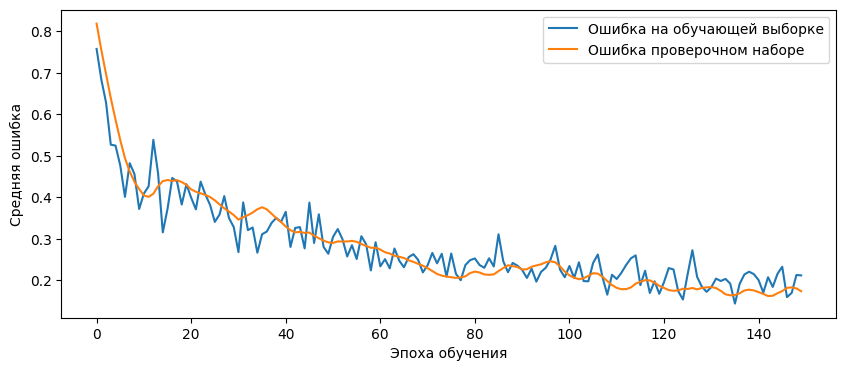

In [366]:
x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(50, activation="relu")(input2)
x2 = Dense(8, activation="tanh")(x2)
x2 = Dense(5, activation = "elu")(x2)

x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(1000, activation="tanh")(input3)
x3 = Dense(20, activation = "elu")(x3)
x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x2, x3]) # Объединяем  ветки

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='relu')(x) # Финальный 

model = Model((input1, input2, input3), x) # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

history = model.fit((x_train, x_train_text1, x_train_text2), 
                    y_train, 
                    epochs= 150, 
                    validation_split = 0.1,
                    verbose=1, shuffle=True)

compare_sharp_loss(history,10,4)
                    


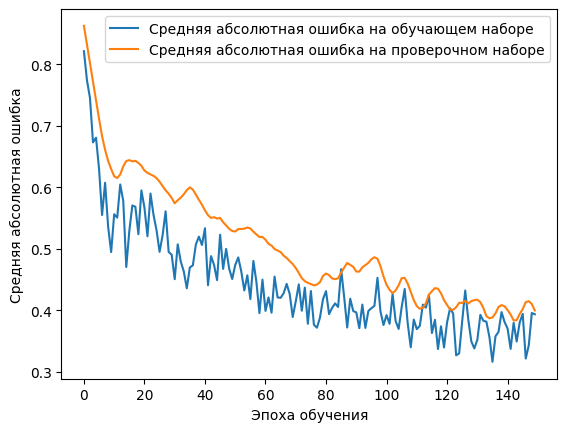

In [367]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()